Force Sensor

In [1]:
import nidaqmx 
import atiiaftt as ati
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CALFILEPATH = "FT44764\FT44764.cal"
INDEX = 1

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()
    reading = task.read()

transform = [0,0,0,0,0,0]

#Bias
sensor = ati.FTSensor()
cal = sensor.createCalibration(CALFILEPATH, INDEX)
sensor.setForceUnits("N".encode("utf-8"))
sensor.setTorqueUnits("N-m".encode("utf-8"))
sensor.setToolTransform(transform, "mm".encode("utf-8"), "deg".encode("utf-8"))

sensor.bias(bias)
output = sensor.convertToFt(reading)
output

[-0.002453692490234971,
 -0.003946494311094284,
 0.0289628766477108,
 4.618336970452219e-05,
 -0.0004614581703208387,
 2.547370058891829e-06]

Test Sensor

In [3]:
current_time = time.time()
duration = 5
readings = []
while time.time() < current_time+duration:
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")

        reading = sensor.convertToFt(task.read())
        print(reading)
        readings.append(reading)

print("Number of Data", len(readings))

[0.002113988157361746, -0.0011630364460870624, 0.0037331280764192343, 0.0007944264216348529, -0.0001108211581595242, -0.0002786967088468373]
[-0.009240667335689068, -0.0052794963121414185, 0.016689583659172058, 0.00014491987531073391, -0.0009577751625329256, -0.00028921797638759017]
[-0.007357388269156218, 0.009419865906238556, 0.033008038997650146, -0.00033136032288894057, -0.00048114056698977947, -0.0001254124945262447]
[-0.00946751981973648, 0.0028024122584611177, 0.020489821210503578, 0.0002653301053214818, -0.0008330886485055089, -0.0007088254787959158]
[-0.0022933022119104862, -0.014566576108336449, 0.008098864927887917, 0.0011782689252868295, -0.0005081201670691371, -0.0001471398863941431]
[-0.004883972462266684, 0.005464258603751659, 0.028791794553399086, -0.0001686055911704898, -0.0006356481462717056, -0.0005649452214129269]
[-0.0023674387484788895, -0.004018994979560375, 0.020590953528881073, 0.00016897950263228267, -0.00011028864537365735, -0.00021621788619086146]
[0.0020994

Initiallize Motor

In [4]:
import numpy as np
import datetime as dt
import csv
import matplotlib.pyplot as plt
import serial
from time import sleep


ENTER = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFC])
EXIT = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFD])
ZERO = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFE])


# AK70-10 24V Motor Limit
P_MIN = -12.5
P_MAX = 12.5
V_MIN = -50  
V_MAX = 50
T_MIN = -25 
T_MAX = 25
KP_MIN = 0
KP_MAX = 500
KD_MIN = 0
KD_MAX = 5

Function

In [5]:
def unpack(data):
    id = data[0]
    pos = ((data[1]*(P_MAX-P_MIN))/(pow(2,16)-1)) + P_MIN
    vel = ((data[2]*(V_MAX-V_MIN))/(pow(2,12)-1)) + V_MIN
    tor = ((data[3]*(T_MAX-T_MIN))/(pow(2,12)-1)) + T_MIN
    return id, pos, vel, tor

def receive():
    global dT, q1_old, q2_old
    # Read the response from the serial port
    received = ser.readline().decode().split()      

    # Print the received bytes
    # print("Received:", received)

    try:
        test = int(received[0])
        response = [int(x) for x in received]
        [id, p, v, t] = unpack(response)

        if id == 1:
            p = -round(p,3)
            t = -t
            if dT == 0:
                v = 0
            else:
                v = round((p - q1_old)/dT,2)
        
        else:
            p = round(p,3)
            t = t
            if dT == 0:
                v = 0
            else:
                v = round((p-q2_old)/dT,2)

        # print the response from the Arduino
        # print([id, p, v, t])

    except (IndexError, ValueError):
        id = None
        p = 0
        v = 0
        t = 0
    return id, p, v, t

def pack_cmd(p_des, v_des, t_ff, kp, kd):
    bufs = []
    def float_to_uint(val, val_min, val_max, bits):
        val_norm = (val - val_min) / (val_max - val_min)
        val_int = int(round(val_norm * ((1 << bits) - 1)))
        return val_int
    
    p_int = float_to_uint(p_des, P_MIN, P_MAX, 16)
    v_int = float_to_uint(v_des, V_MIN, V_MAX, 12)
    t_int = float_to_uint(t_ff, T_MIN, T_MAX, 12)
    kp_int = float_to_uint(kp, KP_MIN, KP_MAX, 12)
    kd_int = float_to_uint(kd, KD_MIN, KD_MAX, 12)
    
    bufs.append((p_int >> 8) & 0xFF)
    bufs.append(p_int & 0xFF)
    bufs.append((v_int >> 4) & 0xFF)
    bufs.append(((v_int & 0xF) << 4) | ((kp_int >> 8) & 0xF))
    bufs.append(kp_int & 0xFF)
    bufs.append((kd_int >> 4) & 0xFF)
    bufs.append(((kd_int & 0xF) << 4) | ((t_int >> 8) & 0xF))
    bufs.append(t_int & 0xFF)

    return bufs

Construct Serial Connection

In [6]:
# open the serial port
ser = serial.Serial('COM3', 115200, timeout=1)


Set Zero

In [ ]:
print("Begining")


q1_old = 0
pos2_old = 0
dT = 0

#M1
print("Starting Zero Position M1")
ser.write(bytes([0x01])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x01])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()



#M2
print("Starting Zero Position M2")
ser.write(bytes([0x02])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x02])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()

print("Finishing Zero Position")


Enter Motor and Re-bias Force Sensor

In [36]:
##Motor

dT = 0

#M1
print("Starting Enter Motors")
ser.write(bytes([0x01])+ENTER)
[id, p, v, t] = receive()
if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

#M2
ser.write(bytes([0x02])+ENTER)
[id, p, v, t] = receive()

if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

q1_old = q1
q2_old = q2


##Sensor

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()

sensor.bias(bias)

Starting Enter Motors


Running

In [37]:
start_time = dt.datetime.today().timestamp()
t = 0
l1 = 0.275
l2 = 0.24
l4 = 0.01
q0 = np.deg2rad(18)
logs = list()
motor_logs = list()
readings = list()

t_mapping = 1/1.35

x = l1*np.sin(q1) + l2*np.cos(q2)
y = l1*np.cos(q1) - l2*np.sin(q2)

time = 0
record_duration = 20

print("Start Controling")
while time < record_duration:
    start_time = dt.datetime.today().timestamp()

    log = list()
    log.append(time)

    q1_old = q1
    q2_old = q2

    x_old = x
    y_old = y


    T1 = 0
    T2 = 0

    
    
    log.append(T1)
    log.append(T2)


    command1 = bytes(pack_cmd(0,0,-T1*t_mapping,0,0)) #(pos,vel,torque,kp,kd)
    command2 = bytes(pack_cmd(0,0,T2*t_mapping,0,0)) #(pos,vel,torque,kp,kd)

    #M1
    ser.write(bytes([0x01])+command1)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    #M2
    ser.write(bytes([0x02])+command2)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    log.append(t1)
    log.append(t2)

    log.append(q1)
    log.append(q2)

    x = l1*np.sin(q1) + l2*np.cos(q2)
    y = l1*np.cos(q1) - l2*np.sin(q2)

    log.append(x)
    log.append(y)

    if time!= 0:
        x_dot = (x-x_old)/dT
        y_dot = (y-y_old)/dT
    
    else:
        x_dot = 0
        y_dot = 0

    log.append(x_dot)
    log.append(y_dot)

    #Estimate CF
    A = q0-q1+2*q2
    B = q0-q1
    C = q0-2*q1+q2
    D = q0+q2
    Fx = -((T1*l2*(np.sin(A)+np.sin(B))+T2*l1*(np.sin(C)-np.sin(D)))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))
    Fy = (T1*l2*(np.cos(B)+np.cos(C))+T2*l1*(np.cos(D)-np.cos(A))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))    

    log.append(Fx)
    log.append(Fy)

    motor_logs.append(log)


    #Sensor
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
        reading = sensor.convertToFt(task.read())

  
    #print(reading)
    
    readings.append(reading)

    log.append(-reading[1])
    log.append(-reading[0])

    logs.append(log)
    
    # print("Progress", f'{round(time/record_duration*100,3)}%')
    dT = dt.datetime.today().timestamp()-start_time
    time+= dT

ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()
    

print("finish")
# print(logs)


Start Controling
finish


Emergency Exit

In [ ]:
ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()


In [38]:
print("Data Sample Size", len(readings))
COLUMNS = ["Force X", "Force Y", "Force Z", "Torque X", "Torque Y", "Torque Z"]
readings
arrays = np.array([np.array(item) for item in readings])

arrays_transpose = arrays.transpose()
df = pd.DataFrame([])
for i in range(len(COLUMNS)):
    df[COLUMNS[i]] = arrays_transpose[i]

print(df)

Data Sample Size 690
      Force X   Force Y   Force Z  Torque X  Torque Y  Torque Z
0    0.404576  0.257988  0.426647  0.007006  0.014032 -0.011253
1    0.526689 -0.065526  0.272653 -0.008022  0.025840 -0.025782
2    0.342965  0.387879 -0.590885 -0.024232  0.006018 -0.032970
3    0.217000  0.377174  0.169075  0.005092  0.019901 -0.023630
4   -0.067471 -0.150266  0.154362 -0.001898 -0.009736 -0.017676
..        ...       ...       ...       ...       ...       ...
685  0.296518  0.381879 -0.210153 -0.023639  0.002689 -0.008873
686 -0.299879  0.510231  0.202459 -0.045503 -0.021713 -0.009821
687  0.298806  0.216571 -0.111835  0.001208  0.011004 -0.012317
688 -0.018363  0.334060 -0.147664 -0.048510 -0.014946 -0.011351
689 -0.407205  0.121086 -0.256753 -0.041302 -0.036599 -0.006891

[690 rows x 6 columns]


In [39]:
print(logs)
logs_COLUMNS = ["Time", "T1", "T2", "t1", "t2", "q1", "q2", "x", "y", "x_dot", "y_dot", "Fx", "Fy", "Fx_Mea", "Fy_Mea"]

logs_arrays = np.array([np.array(item) for item in logs])

logs_arrays_transpose = logs_arrays.transpose()
df_log = pd.DataFrame([])
for i in range(len(logs_COLUMNS)):
    df_log[logs_COLUMNS[i]] = logs_arrays_transpose[i]

print(df_log)

[[0, 0, 0, -0.008241758241758212, -0.008241758241758212, 0.173, 0.322, 0.2750030957019663, 0.1949435597583839, 0, 0, -0.0, 0.0, -0.2579876780509949, -0.40457627177238464], [0.027850866317749023, 0, 0, 0.008241758241758212, 0.008241758241758212, 0.172, 0.322, 0.2747321770620847, 0.19499076234584095, -0.009727476222488197, 0.0016948337232501013, -0.0, 0.0, 0.06552574038505554, -0.5266889929771423], [0.0574948787689209, 0, 0, 0.008241758241758212, -0.008241758241758212, 0.172, 0.322, 0.2747321770620847, 0.19499076234584095, 0.0, 0.0, -0.0, 0.0, -0.38787907361984253, -0.34296539425849915], [0.08685088157653809, 0, 0, -0.008241758241758212, -0.008241758241758212, 0.172, 0.322, 0.2747321770620847, 0.19499076234584095, 0.0, 0.0, -0.0, 0.0, -0.37717366218566895, -0.2169995903968811], [0.1148519515991211, 0, 0, -0.008241758241758212, 0.024725274725274637, 0.172, 0.322, 0.2747321770620847, 0.19499076234584095, 0.0, 0.0, -0.0, 0.0, 0.15026579797267914, 0.0674714595079422], [0.14490699768066406, 0

In [40]:
df_log.to_csv("No_T1_T2.csv")

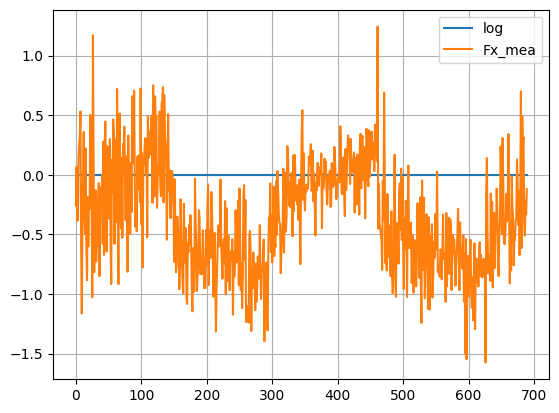

In [41]:
X = df_log.index
Y = df_log["Fx"]
plt.plot(X, Y, label="log")
plt.grid()
plt.plot(X, df_log["Fx_Mea"], label="Fx_mea")
plt.legend()